## Importing libraries and initialisation

In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

### Loading and preparing data

In [2]:
df_l = pd.read_csv('data/listings.csv', low_memory = False)

In [3]:
df_l.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,gmaps_result,centre_transit_time
0,23163,https://www.airbnb.com/rooms/23163,20200229181007,2020-03-01,"Quiet 1BR directly in the Centre, Air-conditio...","Unique and elegant apartment rental in Prague,...",Unique and elegant apartment rental in Prague ...,"Unique and elegant apartment rental in Prague,...",none,Check my guidebook for this apartment to disco...,"To help you with your first steps in Prague, I...",The closest METRO station is called „Narodni t...,NaN,"Of course, you can contact me anytime during y...",Thank you for treating the property like it wa...,NaN,NaN,https://a0.muscache.com/im/pictures/01bbe32c-3...,NaN,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Prague, Czech Republic","Hello, \r\nglad to see that you are interested...",within an hour,97%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,69.0,69.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Prague, Czech Republic, Czech Republic",Staré Město,Praha 1,NaN,Prague,Czech Republic,11000,Prague,"Prague, Czech Republic",CZ,Czech Republic,50.08229,14.41552,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",775.0,"$3,717.00",NaN,NaN,"$2,546.00",NaN,2,$636.00,1,365,1,7,365,365,5.6,365.0,today,t,19,40,70,288,2020-03-01,19,3,2010-09-20,2019-07-27,98.0,9.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,f,f,69,68,0,0,0.17,{'destination_addresses': ['Staroměstské nám. ...,9.883333


In [4]:
# these columns were chosen as valuable for our analysis as features which could affect our target variable "price"
# 
cols_to_keep = ['host_since', 'host_response_time', 'host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'number_of_reviews', 'review_scores_rating', 'cancellation_policy', 'centre_transit_time']

In [5]:
df_lf = df_l[cols_to_keep]

In [6]:
# ration of null values in our variables (our target price doesn't have any nulls)
features = df_lf.isnull().sum() / df_lf.shape[0]
features.sort_values(ascending = False)

security_deposit          0.280220
cleaning_fee              0.194849
host_response_time        0.187157
review_scores_rating      0.137157
beds                      0.008173
bedrooms                  0.001442
bathrooms                 0.000481
host_is_superhost         0.000069
host_since                0.000069
cancellation_policy       0.000000
price                     0.000000
guests_included           0.000000
accommodates              0.000000
room_type                 0.000000
neighbourhood_cleansed    0.000000
extra_people              0.000000
number_of_reviews         0.000000
centre_transit_time       0.000000
dtype: float64

In [7]:
# these variables have prices encoded as strings with dollar signs
df_lf[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].head()

,price,security_deposit,cleaning_fee,extra_people
0,"$3,717.00","$2,546.00",NaN,$636.00
1,"$2,493.00","$2,546.00",NaN,$636.00
2,"$2,540.00","$5,092.00",$458.00,$255.00
3,"$2,032.00","$3,819.00",$458.00,$204.00
4,"$1,039.00",$0.00,$350.00,$0.00


In [8]:
def convert_prices(df, cols):
    """Function for converting strings with a dollar sign to floats

    Parameters:
    df (DataFrame): Description of arg1,
    cols (list): Column names which are going to be affected

    Returns:
    DataFrame: New dataframe with converted values

    """
    for col in cols:
        df[col] = df[col].str.replace('[$|,]', '').astype(float)
    return df

In [9]:
df_lf = convert_prices(df_lf, ['price', 'security_deposit', 'cleaning_fee', 'extra_people'])

In [10]:
df_lf[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].head()

,price,security_deposit,cleaning_fee,extra_people
0,3717.0,2546.0,NaN,636.0
1,2493.0,2546.0,NaN,636.0
2,2540.0,5092.0,458.0,255.0
3,2032.0,3819.0,458.0,204.0
4,1039.0,0.0,350.0,0.0


In [11]:
# filling missing values of float variables by their mean
for col in df_lf.dtypes[df_lf.dtypes == 'float'].index.tolist():
    df_lf[col] = df_lf[col].fillna(df_lf[col].mean())

In [12]:
df_lf[['price', 'security_deposit', 'cleaning_fee', 'extra_people']].head()

,price,security_deposit,cleaning_fee,extra_people
0,3717.0,2546.0,508.480508,636.0
1,2493.0,2546.0,508.480508,636.0
2,2540.0,5092.0,458.000000,255.0
3,2032.0,3819.0,458.000000,204.0
4,1039.0,0.0,350.000000,0.0


### Converting date in host_since into relative days to present day

In [13]:
df_lf['host_since'] = df_lf['host_since'].apply(lambda x: (pd.to_datetime('2020-03-01') - pd.to_datetime(x)).days)

### Correlation matrix will reveal highly correlated features

In [14]:
corr_matrix = df_lf.corr().abs()

# the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

In [15]:
sol.reset_index()[0:10]

,level_0,level_1,0
0,accommodates,beds,0.744801
1,accommodates,bedrooms,0.647316
2,bedrooms,beds,0.636492
3,accommodates,guests_included,0.523426
4,accommodates,bathrooms,0.367238
5,bathrooms,beds,0.364703
6,bedrooms,guests_included,0.353369
7,beds,guests_included,0.340453
8,bathrooms,bedrooms,0.322128
9,accommodates,cleaning_fee,0.297937


### Looks like 'beds', 'bedrooms' and 'accommodates' are all highly correlated, for interpretability we will drop the first two

In [16]:
df_lf = df_lf.drop(['beds', 'bedrooms'], axis = 1)

# Preparing categorical variables

### We can encode the categorical column containing the information about superhsot to a boolean series

In [17]:
df_lf['host_is_superhost'] = df_lf['host_is_superhost'].replace({'t': 1, 'f': 0})

In [18]:
df_lf.head()

,host_since,host_response_time,host_is_superhost,neighbourhood_cleansed,room_type,accommodates,bathrooms,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,cancellation_policy,centre_transit_time
0,4092.0,within an hour,1.0,Praha 1,Entire home/apt,4,1.0,3717.0,2546.0,508.480508,2,636.0,19,98.0,moderate,9.883333
1,4092.0,within an hour,1.0,Praha 1,Entire home/apt,4,1.0,2493.0,2546.0,508.480508,2,636.0,113,95.0,moderate,4.766667
2,3597.0,within an hour,1.0,Praha 7,Entire home/apt,6,1.0,2540.0,5092.0,458.000000,4,255.0,345,97.0,moderate,16.900000
3,3597.0,within an hour,1.0,Praha 1,Entire home/apt,4,1.5,2032.0,3819.0,458.000000,3,204.0,246,99.0,moderate,13.450000
4,3585.0,within an hour,1.0,Praha 3,Entire home/apt,2,1.0,1039.0,0.0,350.000000,1,0.0,411,96.0,moderate,20.683333


### One hot encoding other categorical variables

In [19]:
cat_cols= df_lf.dtypes[df_lf.dtypes == 'object'].index.tolist()
cat_cols

['host_response_time',
 'neighbourhood_cleansed',
 'room_type',
 'cancellation_policy']

In [20]:
def group_cat(df, col, new_value_name = 'Other', threshold = 0.01):
    """Function which will group underrepresented categories into a new 'Other'
       category, one hot encodes the column and appends it to the original dataframe

    Parameters:
    df (DataFrame): Input dataframe
    col (string): column which we want to transform
    new_value_name (string): name of a new column which is going to be created after grouping underrepresented categories together
    threshold (float): what's the minimal share of a category in a feature not to be grouped into the 'Other' category

    Returns:
    DataFrame: New dataframe with column transformed (grouping + OHE) and the original column dropped

    """
    new_col = col + '_new'
    df_g = df.groupby(col)[df.columns[0]].count().reset_index()
    df_g['ratio'] = df_g[df.columns[0]] / df_lf.shape[0]
    df_g[new_col] = df_g.apply(lambda x: x[col] if (x['ratio'] > threshold) else new_value_name, axis = 1)
    print(df_g.groupby(new_col)['ratio'].sum())
    
    s = df.merge(df_g[[col, new_col]], on = col)[new_col]
    ohe = pd.get_dummies(s, prefix = col)
    return df.merge(ohe, left_index = True, right_index = True).drop(col, axis = 1)

In [21]:
# after applying on the original dataframe we can see the shares of individual categories after transformation
for col in cat_cols:    
    df_lf = group_cat(df_lf, col, threshold = 0.05)

host_response_time_new
Other                 0.011882
within a day          0.050618
within a few hours    0.069712
within an hour        0.680632
Name: ratio, dtype: float64
neighbourhood_cleansed_new
Other       0.153866
Praha 1     0.291762
Praha 10    0.053485
Praha 2     0.159527
Praha 3     0.136967
Praha 5     0.088044
Praha 7     0.056612
Praha 8     0.059654
Name: ratio, dtype: float64
room_type_new
Entire home/apt    0.782425
Other              0.048331
Private room       0.169159
Name: ratio, dtype: float64
cancellation_policy_new
Other                          0.011829
flexible                       0.247486
moderate                       0.360287
strict_14_with_grace_period    0.380313
Name: ratio, dtype: float64


In [22]:
df_lf.head()

,host_since,host_is_superhost,accommodates,bathrooms,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,review_scores_rating,centre_transit_time,host_response_time_Other,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Other,neighbourhood_cleansed_Praha 1,neighbourhood_cleansed_Praha 10,neighbourhood_cleansed_Praha 2,neighbourhood_cleansed_Praha 3,neighbourhood_cleansed_Praha 5,neighbourhood_cleansed_Praha 7,neighbourhood_cleansed_Praha 8,room_type_Entire home/apt,room_type_Other,room_type_Private room,cancellation_policy_Other,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period
0,4092.0,1.0,4,1.0,3717.0,2546.0,508.480508,2,636.0,19,98.0,9.883333,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,4092.0,1.0,4,1.0,2493.0,2546.0,508.480508,2,636.0,113,95.0,4.766667,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3597.0,1.0,6,1.0,2540.0,5092.0,458.000000,4,255.0,345,97.0,16.900000,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,3597.0,1.0,4,1.5,2032.0,3819.0,458.000000,3,204.0,246,99.0,13.450000,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,3585.0,1.0,2,1.0,1039.0,0.0,350.000000,1,0.0,411,96.0,20.683333,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


### Dropping rows with remaining null values

In [23]:
df_lf.isnull().sum().sum()

2

In [24]:
df_lf = df_lf.dropna()

# Preparing the 'price' variable

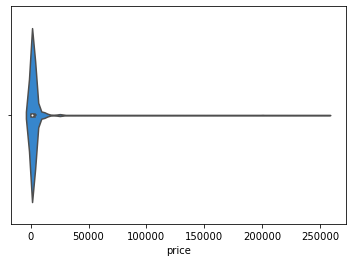

In [25]:
sns.violinplot(df_lf['price'], color = '#1e88e5')

### There are some suspicious outlier prices upwards of 50000CZK/day, we are going to drop the listings in the top 10 percentile

In [26]:
cutoff = df_lf['price'].quantile(.9)

In [27]:
df_lf = df_lf[df_lf['price'] < cutoff]

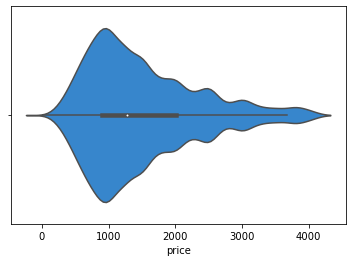

In [28]:
sns.violinplot(df_lf['price'], color = '#1e88e5')

# Fitting a model

In [29]:
import sklearn.model_selection
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
import shap

### Using XGBoost regression model to predict the price variable

In [30]:
y = df_lf['price']

In [31]:
X = df_lf.drop('price', axis = 1)

In [32]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20)

In [33]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [34]:
gbm = XGBRegressor(n_estimators=1000)

In [35]:
# running the XGB training with early stopping to prevent overfitting
m = gbm.fit(X_train, y_train, early_stopping_rounds=50, eval_set = eval_set)

[0]	validation_0-rmse:1294.94885	validation_1-rmse:1283.37463
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1012.61523	validation_1-rmse:1008.48602
[2]	validation_0-rmse:833.32642	validation_1-rmse:836.44873
[3]	validation_0-rmse:723.22479	validation_1-rmse:736.59875
[4]	validation_0-rmse:654.87335	validation_1-rmse:678.65912
[5]	validation_0-rmse:612.51044	validation_1-rmse:644.02972
[6]	validation_0-rmse:584.36151	validation_1-rmse:625.37573
[7]	validation_0-rmse:566.53381	validation_1-rmse:615.52918
[8]	validation_0-rmse:549.73291	validation_1-rmse:604.79474
[9]	validation_0-rmse:538.33490	validation_1-rmse:597.98505
[10]	validation_0-rmse:531.90198	validation_1-rmse:595.17926
[11]	validation_0-rmse:526.41248	validation_1-rmse:594.90881
[12]	validation_0-rmse:524.13648	validation_1-rmse:594.10248
[13]	validation_0-rmse:521.02368	validation_1-rmse:594

In [36]:
# the performance of the model is largely irrelevant because we mainly care about the importance of features
m.score(X_test, y_test)

0.4938490181350864

In [37]:
def plot_n_estimators(model):
    
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots(figsize = (10,5))
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE')
    plt.show()

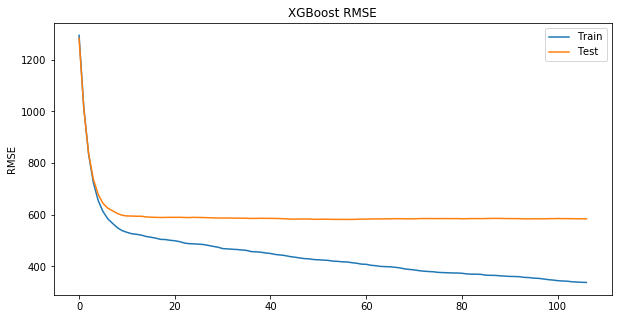

In [38]:
# root square mean error on training and test datasets with increasing iterations
plot_n_estimators(m)

# Using Shapley values to understand the influence of predictors

In [39]:
shap.initjs()
explainer = shap.TreeExplainer(m, feature_perturbation = "tree_path_dependent")
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Explanation of SHAP plots here: [https://github.com/slundberg/shap](https://github.com/slundberg/shap)

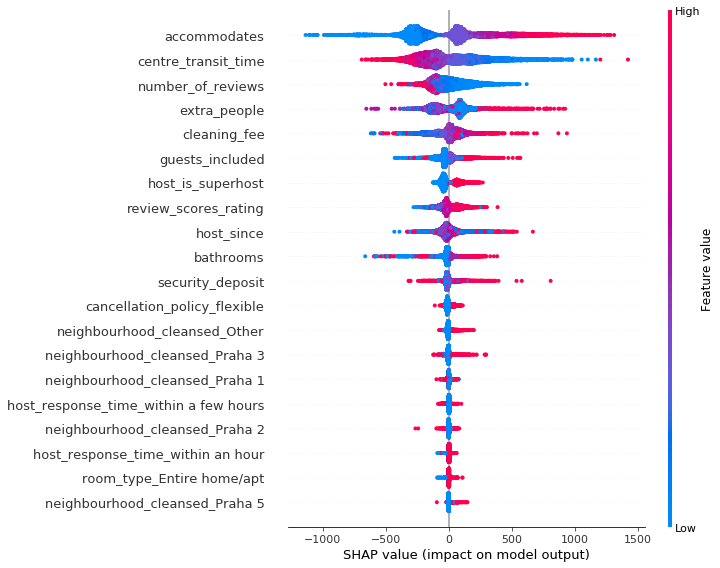

In [40]:
shap.summary_plot(shap_values, X)

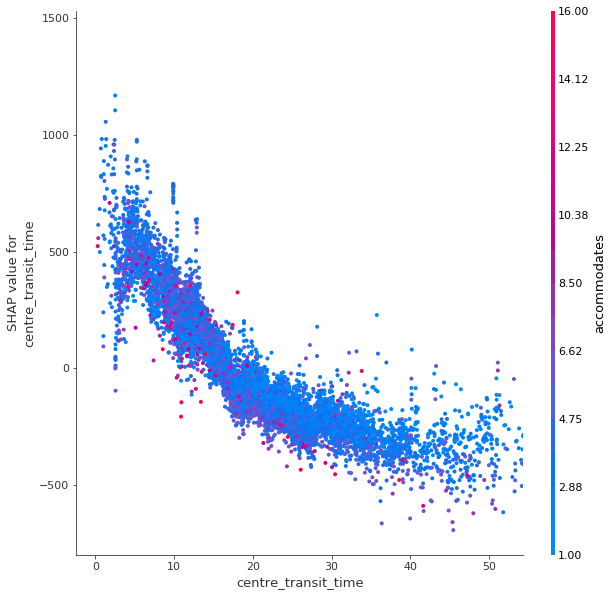

In [41]:
fig, ax = plt.subplots(figsize = (10, 10))
shap.dependence_plot("centre_transit_time", 
                     shap_values, 
                     X, 
                     ax = ax,
                     xmax="percentile(99.5)",
                     interaction_index='accommodates')